Записати і загрузити 5-ти хвилинне відео (сюди, youtube, g-drive) яке повинно містити інформацію про поточний стан справ з проєктом, зокрема:
1. сформулювати проблематику, якщо вона змінилася з моменту презентації (нічо не змінилося, тому ✅)
1. описати дані, провести EDA, описати проблеми, які виникали в процесі збору та підготовки даних
  1. Описати які датасети ми дивилися, показати коротко які там розміри і характеристики
  2. показати розміри COCO
  2. Всі графіки які є
  2. показати scratches
  2. які аугментації, приклади фоток
1. описати спроби тренування (бенчмарки, проблеми, моделі і тп)

# Image Colorization

Available datasets:
- ImageNet (14,197,122 images, *average* 469×387px)
- **COCO** (330,000 images, *median size* 640×480px)
- Places365 (10,000,000 images, 512×512px)
- Image Colorization (25,000 images, 224×224px) (https://www.kaggle.com/datasets/shravankumar9892/image-colorization)

## Installation

## Imports

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import CocoDetection
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import kagglehub

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Create dataset

In [ ]:
ds_path = kagglehub.dataset_download("trungit/coco25k")

images_dir = os.path.join(ds_path, 'images')
anno_file  = os.path.join(ds_path, 'coco25k.txt')
print("Dataset located at:", ds_path)

In [ ]:
# ds_path = "/kaggle/input/coco25k"

In [ ]:
dataset = os.listdir(os.path.join(ds_path, "images"))[:1000]
len(dataset)

1000

In [ ]:
dataset[:5]

['000000501175.jpg',
 '000000200857.jpg',
 '000000269168.jpg',
 '000000520027.jpg',
 '000000486789.jpg']

In [ ]:
train_split, test_split = train_test_split(dataset, test_size=0.3) # 70% vs 30%
val_split, test_split = train_test_split(test_split, test_size=0.5) # 15% vs 15%

In [ ]:
len(train_split), len(val_split), len(test_split)

(700, 150, 150)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_split[:5]

['000000440646.jpg',
 '000000083801.jpg',
 '000000006901.jpg',
 '000000198947.jpg',
 '000000080720.jpg']

# Utils

In [ ]:
import torch
import gc

# Clear cache and collect garbage
torch.cuda.empty_cache()
gc.collect()

# If using multiple GPUs
torch.cuda.ipc_collect()

In [ ]:
!nvidia-smi

Thu May  1 15:40:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P0             27W /   70W |     248MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Approach using from scretch diffusion models

In [ ]:
!pip install segmentation-models-pytorch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.6 MB/s eta 0:00:00


In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
os.listdir('/kaggle/input/coco25k')

['coco25k.txt', 'images']

### Dataset: COCO + LAB conversion

In [ ]:
class Coco25kColorizationDataset(Dataset):
    def __init__(self, txt_file, image_dir, image_size=256):
        with open(txt_file, 'r') as f:
            self.paths = [os.path.join(image_dir, line.strip().split('/')[-1]) for line in f]
        self.image_size = image_size

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB").resize((self.image_size, self.image_size), Image.BICUBIC)
        lab_arr = np.array(img, dtype=np.uint8)
        lab_img = Image.fromarray(lab_arr).convert('LAB')
        lab = np.array(lab_img, dtype=np.float32)
        L = lab[...,0] / 100.0
        ab = (lab[...,1:] - 128.0) / 128.0
        L = torch.from_numpy(L).unsqueeze(0)
        ab = torch.from_numpy(ab.transpose((2,0,1)))
        return L.float(), ab.float()

Diffusion Utilities (DDPM)

In [ ]:
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

### Model architecture

In [ ]:
class Diffusion:
    def __init__(self, timesteps=1000, device='cuda'):
        self.timesteps = timesteps
        self.device = device
        self.betas = linear_beta_schedule(timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.0], device=device), self.alpha_cumprod[:-1]])

        self.sqrt_recip_alphas = (1. / self.alphas).sqrt()
        self.posterior_variance = self.betas * (1. - self.alpha_cumprod_prev) / (1. - self.alpha_cumprod)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_acp = self.alpha_cumprod[t].sqrt().view(-1,1,1,1)
        sqrt_om_acp = (1 - self.alpha_cumprod[t]).sqrt().view(-1,1,1,1)
        return sqrt_acp * x_start + sqrt_om_acp * noise

    def p_losses(self, model, x_start, t, cond):
        noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start, t, noise)
        model_input = torch.cat([cond, x_noisy], dim=1)
        pred = model(model_input)
        return F.mse_loss(noise, pred)

    def p_sample(self, model, x, t, cond):
        betas_t = self.betas[t].view(-1, 1, 1, 1)
        sqrt_one_minus_acp = (1 - self.alpha_cumprod[t]).sqrt().view(-1, 1, 1, 1)
        sqrt_recip_alpha = self.sqrt_recip_alphas[t].view(-1, 1, 1, 1)

        model_input = torch.cat([cond, x], dim=1)
        pred_noise = model(model_input)

        model_mean = sqrt_recip_alpha * (x - betas_t / sqrt_one_minus_acp * pred_noise)

        if t[0] == 0:
            return model_mean
        else:
            noise = torch.randn_like(x)
            posterior_var = self.posterior_variance[t].view(-1, 1, 1, 1)
            return model_mean + torch.sqrt(posterior_var) * noise

    def sample(self, model, cond, shape):
        model.eval()
        x = torch.randn(shape, device=self.device)

        with torch.no_grad():
            for i in reversed(range(self.timesteps)):
                t = torch.full((shape[0],), i, device=self.device, dtype=torch.long)
                x = self.p_sample(model, x, t, cond)
        return x

### UNet (pretrained encoder)

In [ ]:
def make_unet(pretrained=True):
    return smp.Unet(
        encoder_name='resnet18',
        encoder_weights='imagenet' if pretrained else None,
        in_channels=3,  # L + ab noisy
        classes=2,
    )

### Train model

In [ ]:
def train(start_epoch=0, num_epochs=20, resume_ckpt=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = Coco25kColorizationDataset(txt_file=anno_file, image_dir=images_dir)
    idx = list(range(len(dataset)))
    train_idx, temp_idx = train_test_split(idx, test_size=0.3, random_state=42)
    val_idx, test_idx  = train_test_split(temp_idx, test_size=0.5, random_state=42)

    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=64, shuffle=True, num_workers=4)
    val_loader   = DataLoader(Subset(dataset, val_idx),   batch_size=64, shuffle=False, num_workers=4)

    model = make_unet(pretrained=True).to(device)
    diffusion = Diffusion(timesteps=1000, device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Optionally load checkpoint
    if resume_ckpt:
        ckpt = torch.load(resume_ckpt, map_location=device)
        if isinstance(ckpt, dict) and 'model_state' in ckpt:
            model.load_state_dict(ckpt['model_state'])
            optimizer.load_state_dict(ckpt['opt_state'])
            start_epoch = ckpt['epoch'] + 1
            print(f"Resuming from epoch {start_epoch}")
        else:
            model.load_state_dict(ckpt)
            print("Resumed from model weights only (no epoch or optimizer state). Starting from epoch 0.")


    os.makedirs('checkpoints', exist_ok=True)

    for epoch in range(start_epoch, num_epochs):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch} [Train]")
        for L, ab in loop:
            L, ab = L.to(device), ab.to(device)
            t     = torch.randint(0, diffusion.timesteps, (L.size(0),), device=device)
            loss  = diffusion.p_losses(model, x_start=ab, t=t, cond=L)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

        # Validation
        model.eval()
        val_loss = 0.
        with torch.no_grad():
            for L, ab in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
                L, ab = L.to(device), ab.to(device)
                t     = torch.randint(0, diffusion.timesteps, (L.size(0),), device=device)
                val_loss += diffusion.p_losses(model, x_start=ab, t=t, cond=L).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch} Validation Loss: {val_loss:.4f}")

        ckpt_path = f'checkpoints/ckpt_epoch_{epoch}.pth'
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'opt_state': optimizer.state_dict(),
        }, ckpt_path)
        print(f"Checkpoint saved to {ckpt_path}")


if __name__ == '__main__':
    resume_path = 'model_epoch_11.pth'
    train(start_epoch=0, num_epochs=20, resume_ckpt=resume_path)

Resumed from model weights only (no epoch or optimizer state). Starting from epoch 0.


Epoch 0 [Val]: 100%|██████████| 59/59 [01:47<00:00,  1.82s/it]


Epoch 0 Validation Loss: 0.2345
Checkpoint saved to checkpoints/ckpt_epoch_0.pth


Epoch 1 [Val]: 100%|██████████| 59/59 [01:45<00:00,  1.79s/it]


Epoch 1 Validation Loss: 0.2337
Checkpoint saved to checkpoints/ckpt_epoch_1.pth


Epoch 2 [Val]: 100%|██████████| 59/59 [01:45<00:00,  1.79s/it]


Epoch 2 Validation Loss: 0.2353
Checkpoint saved to checkpoints/ckpt_epoch_2.pth


Epoch 3 [Val]: 100%|██████████| 59/59 [01:45<00:00,  1.79s/it]


Epoch 3 Validation Loss: 0.2287
Checkpoint saved to checkpoints/ckpt_epoch_3.pth


Epoch 4 [Val]: 100%|██████████| 59/59 [01:46<00:00,  1.81s/it]


Epoch 4 Validation Loss: 0.2192
Checkpoint saved to checkpoints/ckpt_epoch_4.pth


Epoch 5 [Val]: 100%|██████████| 59/59 [01:46<00:00,  1.80s/it]


Epoch 5 Validation Loss: 0.2179
Checkpoint saved to checkpoints/ckpt_epoch_5.pth


Epoch 6 [Val]: 100%|██████████| 59/59 [01:45<00:00,  1.79s/it]


Epoch 6 Validation Loss: 0.2216
Checkpoint saved to checkpoints/ckpt_epoch_6.pth


Epoch 7 [Val]: 100%|██████████| 59/59 [01:45<00:00,  1.79s/it]


Epoch 7 Validation Loss: 0.2322
Checkpoint saved to checkpoints/ckpt_epoch_7.pth


Epoch 8 [Val]: 100%|██████████| 59/59 [01:45<00:00,  1.79s/it]


Epoch 8 Validation Loss: 0.2404
Checkpoint saved to checkpoints/ckpt_epoch_8.pth


Epoch 9 [Val]: 100%|██████████| 59/59 [01:45<00:00,  1.79s/it]


Epoch 9 Validation Loss: 0.2535
Checkpoint saved to checkpoints/ckpt_epoch_9.pth


Epoch 10 [Val]: 100%|██████████| 59/59 [01:45<00:00,  1.79s/it]


Epoch 10 Validation Loss: 0.3551
Checkpoint saved to checkpoints/ckpt_epoch_10.pth


Epoch 11 [Val]: 100%|██████████| 59/59 [01:45<00:00,  1.79s/it]


Epoch 11 Validation Loss: 0.2160
Checkpoint saved to checkpoints/ckpt_epoch_11.pth


Epoch 12 [Val]: 100%|██████████| 59/59 [01:46<00:00,  1.80s/it]


Epoch 12 Validation Loss: 0.2090
Checkpoint saved to checkpoints/ckpt_epoch_12.pth


Epoch 13 [Val]: 100%|██████████| 59/59 [01:47<00:00,  1.81s/it]


Epoch 13 Validation Loss: 0.1991
Checkpoint saved to checkpoints/ckpt_epoch_13.pth


Epoch 14 [Val]: 100%|██████████| 59/59 [01:44<00:00,  1.77s/it]


Epoch 14 Validation Loss: 0.2346
Checkpoint saved to checkpoints/ckpt_epoch_14.pth


Epoch 15 [Val]: 100%|██████████| 59/59 [01:45<00:00,  1.78s/it]


Epoch 15 Validation Loss: 1.2759
Checkpoint saved to checkpoints/ckpt_epoch_15.pth


Epoch 16 [Val]: 100%|██████████| 59/59 [01:44<00:00,  1.77s/it]


Epoch 16 Validation Loss: 0.1938
Checkpoint saved to checkpoints/ckpt_epoch_16.pth


Epoch 17 [Train]:  34%|███▎      | 92/274 [02:55<04:09,  1.37s/it, loss=0.228]

### Inference model

In [ ]:
def inference(input_gray_path, output_path, checkpoint=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = make_unet(True).to(device)
    if checkpoint: model.load_state_dict(torch.load(checkpoint, map_location=device))
    diffusion = Diffusion(1000, device)

    img = Image.open(input_gray_path).convert('L').resize((256,256), Image.BICUBIC)
    L = torch.from_numpy(np.array(img)/100.0).unsqueeze(0).unsqueeze(0).to(device).float()

    ab_gen = diffusion.sample(model, cond=L, shape=(1,2,256,256))
    ab_gen = ab_gen.squeeze(0).cpu().numpy().transpose(1,2,0)
    ab_gen = (ab_gen * 128.0) + 128.0  # de-normalize

    L_ = (L.squeeze().cpu().numpy() * 100.0).astype(np.uint8)
    lab_img = np.stack([L_, ab_gen[:,:,0], ab_gen[:,:,1]], axis=-1).astype(np.uint8)
    rgb = Image.fromarray(lab_img, mode='LAB').convert('RGB')
    rgb.save(output_path)
    print(f"Saved colorized image to {output_path}")

if __name__ == '__main__':
    # train()  # uncomment to train
    path_to_input_im = os.path.join(ds_path, "images", os.listdir(images_dir)[17177])
    path_to_gen_im = "gen_" + path_to_input_im.split('/')[-1]
    inference(path_to_input_im, path_to_gen_im, checkpoint='checkpoints/model_epoch_6.pth')

Saved colorized image to gen_000000461248.jpg


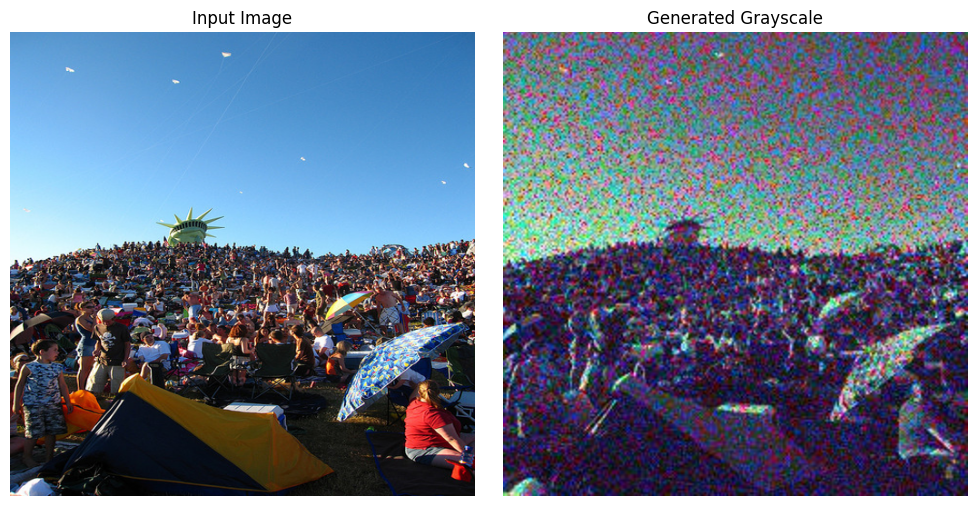

In [ ]:
from PIL import Image
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

input_image = Image.open(path_to_input_im).convert("RGB").resize((512, 512))
generated_image = Image.open(path_to_gen_im).convert("RGB").resize((512, 512))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_image)
ax[0].set_title("Input Image")
ax[0].axis("off")

ax[1].imshow(generated_image)
ax[1].set_title("Generated Grayscale")
ax[1].axis("off")

plt.tight_layout()
plt.show()